# Data processing

Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (r2_score, classification_report, confusion_matrix, 
                             accuracy_score, roc_auc_score, roc_curve, 
                             precision_recall_curve, average_precision_score,
                             cohen_kappa_score, matthews_corrcoef)
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.neural_network import MLPClassifier
import gensim
from gensim import corpora
from scipy.optimize import minimize

In [3]:

import sklearn
import scipy
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import discriminant_analysis

import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from imblearn.over_sampling import RandomOverSampler
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
import pickle

Import Data File 

In [4]:
df=pd.read_csv('creditcard.csv')
df.isnull().values.any()

False

In [5]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# Remove duplicates
print(df.shape)
df.drop_duplicates(keep='first', inplace=True)
print(df.shape)

(284807, 31)
(283726, 31)


In [8]:
# Set parameters for graph sizes, for labels
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

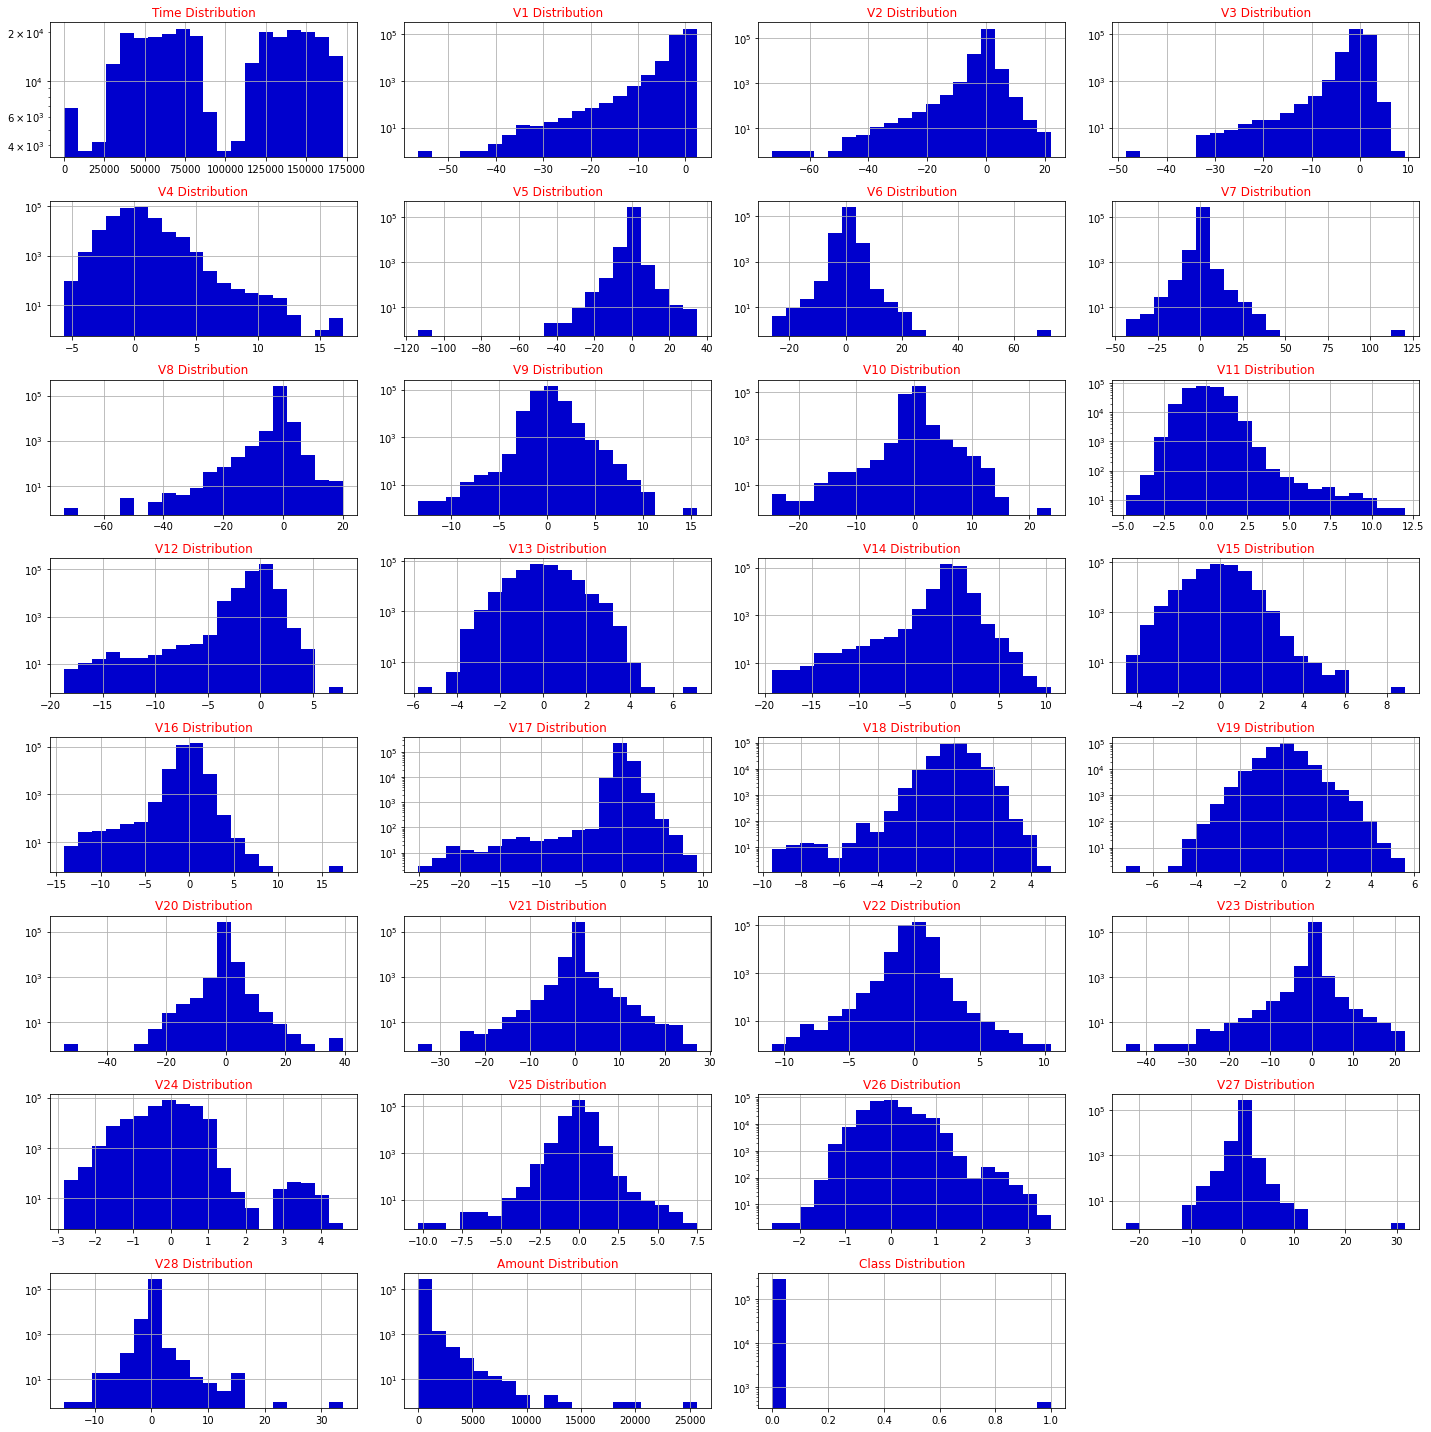

In [9]:
# Visualing histograms of 28 features
def draw_histograms(dataframe, features, rows, cols):
    fig = plt.figure(figsize = (20, 20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins=20, ax=ax, facecolor='mediumblue')
        ax.set_title(feature+" Distribution", color='Red')
        ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()
draw_histograms(df, df.columns, 8, 4)

In [10]:
# Count the occurrences of fraud and no fraud 
occ = df['Class'].value_counts()
occ

0    283253
1       473
Name: Class, dtype: int64

Text(0, 0.5, 'Frequency')

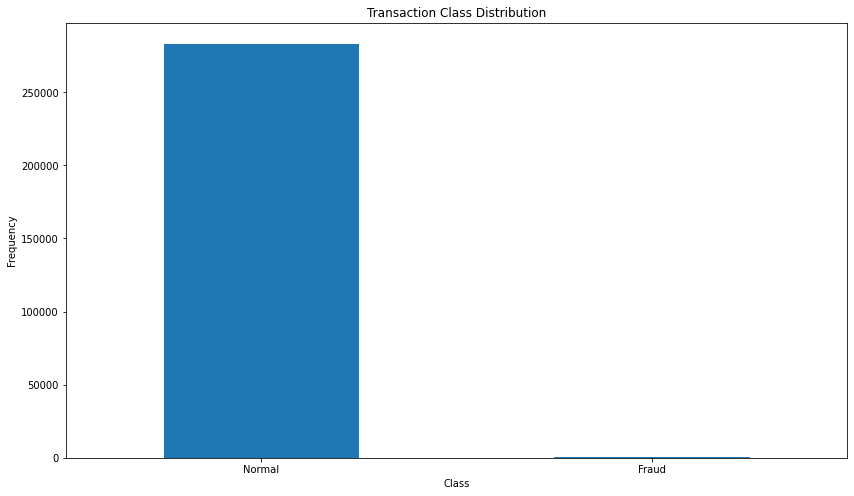

In [11]:
# Creating a bar chart comparison of normal and fraudulent transactions
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [12]:
# Create separate fraud and normal datasets 
fraud = df[df['Class']==1]
normal = df[df['Class']==0]

In [13]:
# Plotting the transactions with time
class_0 = normal["Time"]
class_1 = fraud["Time"]

hist_data = [class_0, class_1]
group_labels = ['Normal', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, 
                         show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', 
                     xaxis=dict(title='Time (s)'))
iplot(fig, filename='dist_only')

Fraudulent transactions have a distribution more even than valid transactions - they are equally distributed in time, including the low accurate transaction times, during the night in the Europe timezone.

In [14]:
# Analyze more amount of information from the transaction data
fraud.Amount.describe()

count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [15]:
normal.Amount.describe()

count    283253.000000
mean         88.413575
std         250.379023
min           0.000000
25%           5.670000
50%          22.000000
75%          77.460000
max       25691.160000
Name: Amount, dtype: float64

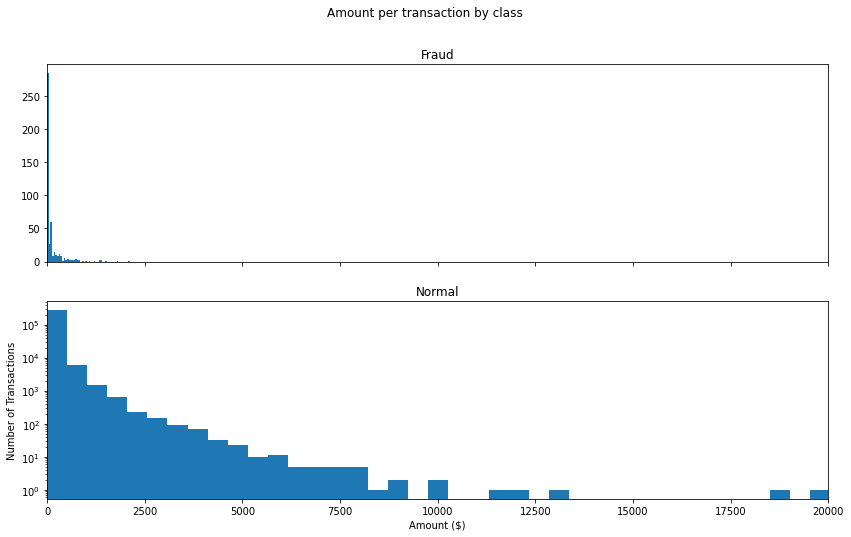

In [16]:
# Plot the amount per transaction and total number of transactions
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins=bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins=bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Text(0.5, 1.0, 'Heatmap of Correlation')

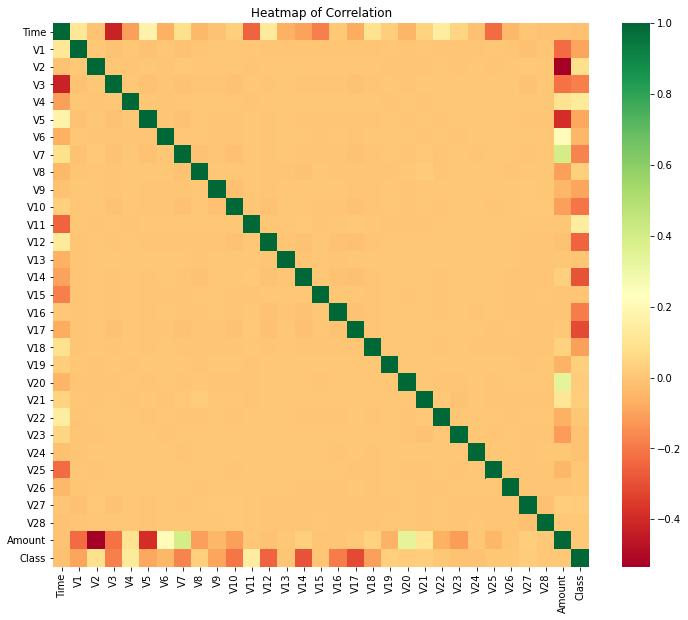

In [17]:
# Plot the heatmap of correlation among 28 features
corr = df.corr()
plt.figure(figsize=(12, 10))
heat = sns.heatmap(data=corr, cmap="RdYlGn")
plt.title('Heatmap of Correlation')

In [18]:
# Print the ratio of fraud cases
ratio_cases = occ/len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')

Ratio of fraudulent cases: 0.001667101358352777
Ratio of non-fraudulent cases: 0.9983328986416472


The ratio of fraudulent transactions is very low

# Data visualization

In [19]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    
    # Convert the DataFrame into two variables
    # X: data columns (V1 - V28)
    # y: lable column (0, 1)
    
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

In [20]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y==0, 0], X[y==0, 1], label="Class #0", 
                alpha=0.5, linewidth=0.15)
    plt.scatter(X[y==1, 0], X[y==1, 1], label="Class #1", 
                alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [21]:
# Create X and y from the prep_data function 
X, y = prep_data(df)

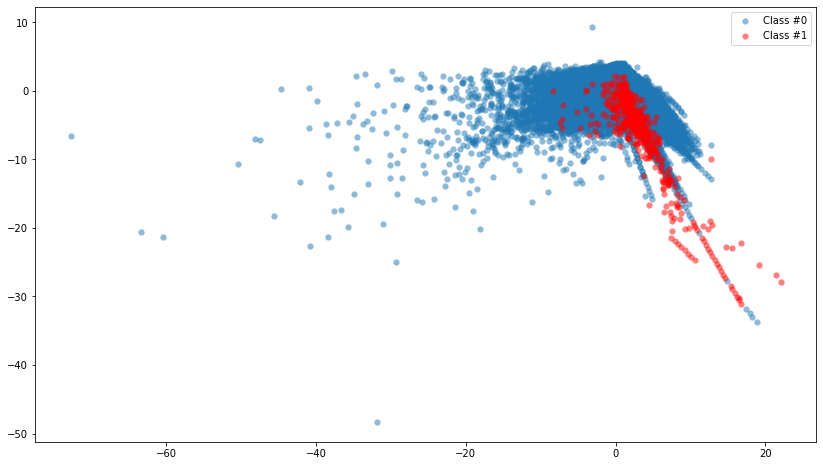

In [22]:
# Plot data on X and y
plot_data(X, y)

Use resampling methods **on the training set**, not on the test set.
The goal is to produce a better model by providing balanced data.


# Increase successful detections with data resampling




In [23]:
# Get the values of X and y for resampling
X = df.drop('Class', axis=1).values
y = df['Class'].values
# Split data set to a training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 0)


In [24]:
# Define resampling method 
method = SMOTE(kind='borderline1')


In [25]:
# Run the prep_data function
X, y = prep_data(df)

In [26]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')


X shape: (283726, 28)
y shape: (283726,)


In [27]:
# Create the resampled feature sets
X_resampled, y_resampled = method.fit_sample(X, y)


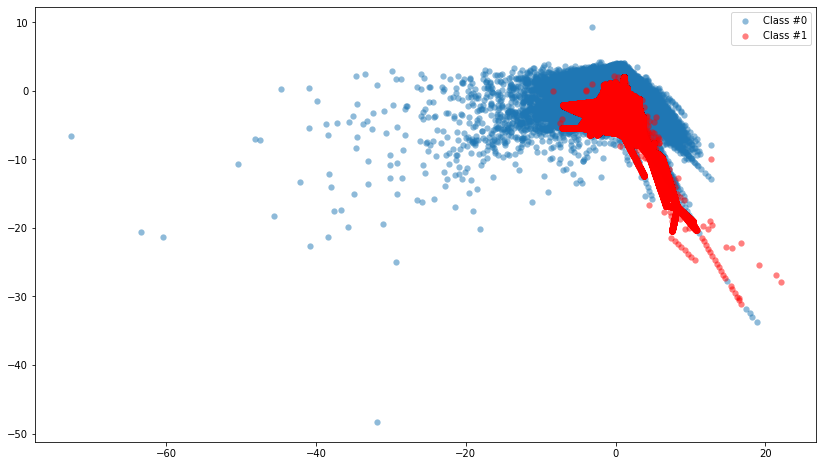

In [28]:
# Plot the resampled data
plot_data(X_resampled, y_resampled)

In [29]:
pd.value_counts(pd.Series(y))


0    283253
1       473
dtype: int64

In [30]:
# Count the total attributes after resampling
pd.value_counts(pd.Series(y_resampled))

1    283253
0    283253
dtype: int64

In [31]:
# Compare data set before and after resampling.
def compare_plot(X: np.ndarray, y: np.ndarray, 
                 X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y==0, 0], X[y==0, 1], 
                label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y==1, 0], X[y==1, 1], label="Class #1", 
                alpha=0.5, linewidth=0.15, c='r')
    plt.title('Actual data')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled==0, 0], X_resampled[y_resampled==0, 1], 
                label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled==1, 0], X_resampled[y_resampled==1, 1], 
                label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

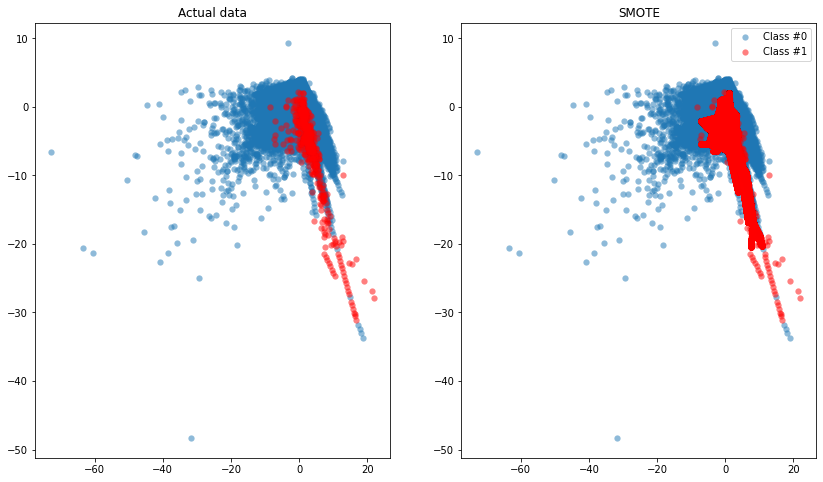

In [32]:
# Plot the data before and after resampling
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')


# Logistic regression with SMOTE (train the model and predict results with original data set)



*   The goal is not to predict the synthetic samples
*   Test data should be free of duplicates and synthetic data
*   Train the model without resampling data set


In [33]:
# Define which resampling method and which ML model to use 
resampling = BorderlineSMOTE()


In [34]:
# Define ML model
model_LR = LogisticRegression(solver ='liblinear', max_iter=150)

In [35]:
# Split data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
# Train and predict the model with split data
model_LR.fit(X_train, y_train) 
predicted = model_LR.predict(X_test)

In [37]:
# Number of decimal places based on number of samples
dec = np.int64(np.ceil(np.log10(len(y_test))))

# Print evaluation metrics  
print('CONFUSION MATRIX')
print(confusion_matrix(y_test, predicted), '\n')
print('CLASSIFICATION REPORT')
print(classification_report(y_test, predicted, digits=dec))
print('SCALAR METRICS')
format_str = '%%13s = %%.%if' % dec
print(format_str % ('MCC', matthews_corrcoef(y_test, predicted)))
print(format_str % ('AUPRC', average_precision_score(y_test, predicted)))
print(format_str % ('AUROC', roc_auc_score(y_test, predicted)))
print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, predicted)))
print(format_str % ('Accuracy', accuracy_score(y_test, predicted)))

CONFUSION MATRIX
[[56649    10]
 [   42    45]] 

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0    0.99926   0.99982   0.99954     56659
           1    0.81818   0.51724   0.63380        87

    accuracy                        0.99908     56746
   macro avg    0.90872   0.75853   0.81667     56746
weighted avg    0.99898   0.99908   0.99898     56746

SCALAR METRICS
          MCC = 0.65013
        AUPRC = 0.42394
        AUROC = 0.75853
Cohen's kappa = 0.63337
     Accuracy = 0.99908




# Logistic regression SMOTE after resampling (train the model with resampled data set, predict the result with the original test set)

In [38]:
# Split resampled data X_resampled and y_resampled, into a training and a test set 
X_train, X_smote_test, y_train, y_smote_test = train_test_split(X_resampled, y_resampled, 
                                                                test_size=0.2, random_state=0)

In [39]:
# Fit the model onto the training data
model_LR.fit(X_train, y_train) 


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=150,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
predicted = model_LR.predict(X_test) #X_test : original test set

In [41]:
# Number of decimal places based on number of samples
dec = np.int64(np.ceil(np.log10(len(y_test))))
    
print('CONFUSION MATRIX')
print(confusion_matrix(y_test, predicted), '\n')
    
print('CLASSIFICATION REPORT')
print(classification_report(y_test, predicted, digits=dec))
    
print('SCALAR METRICS')
format_str = '%%13s = %%.%if' % dec
print(format_str % ('MCC', matthews_corrcoef(y_test, predicted)))
print(format_str % ('AUPRC', average_precision_score(y_test, predicted)))
print(format_str % ('AUROC', roc_auc_score(y_test, predicted)))
print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, predicted)))
print(format_str % ('Accuracy', accuracy_score(y_test, predicted)))

CONFUSION MATRIX
[[56205   454]
 [   10    77]] 

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0    0.99982   0.99199   0.99589     56659
           1    0.14501   0.88506   0.24919        87

    accuracy                        0.99182     56746
   macro avg    0.57242   0.93852   0.62254     56746
weighted avg    0.99851   0.99182   0.99474     56746

SCALAR METRICS
          MCC = 0.35640
        AUPRC = 0.12852
        AUROC = 0.93852
Cohen's kappa = 0.24721
     Accuracy = 0.99182


In [42]:
# Save the MCC, AUROC, Accuracy scores
MCC_scores = {
      'Logistic_reg': {
        'MCC': matthews_corrcoef(y_test, predicted),
        'Accuracy': accuracy_score(y_test, predicted),
        'AUROC': roc_auc_score(y_test, predicted)
      },
}

The MCC score (0.35) after testing the LR model on the original test set is lower than that (0.65) on a synthetic test set, which means we should try the ML model on the actual test set to maximize the MCC score

#Support vector classifier


In [43]:
# Define the model as the SVC
pipeline_svc = Pipeline([
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

In [44]:
# Set up the parameters for the model
param_grid_svc = [{
    'model__loss': ['log'],
    'model__penalty': ['l1', 'l2'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20)
}, {
    'model__loss': ['hinge'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20),
    'model__class_weight': [None, 'balanced']
}]

In [45]:
model_SVC = GridSearchCV(estimator=pipeline_svc, param_grid=param_grid_svc,
                        n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, 
                        return_train_score=False)

In [46]:
 # Fit the model to training set
 model_SVC.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  6.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=False,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',
                         

In [47]:
# Obtain predictions from the test data 
predicted = model_SVC.predict(X_test)

In [48]:
# Number of decimal places based on number of samples
dec = np.int64(np.ceil(np.log10(len(y_test))))
    
print('CONFUSION MATRIX')
print(confusion_matrix(y_test, predicted), '\n')
    
print('CLASSIFICATION REPORT')
print(classification_report(y_test, predicted, digits=dec))
    
print('SCALAR METRICS')
format_str = '%%13s = %%.%if' % dec
print(format_str % ('MCC', matthews_corrcoef(y_test, predicted)))
print(format_str % ('AUPRC', average_precision_score(y_test, predicted)))
print(format_str % ('AUROC', roc_auc_score(y_test, predicted)))
print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, predicted)))
print(format_str % ('Accuracy', accuracy_score(y_test, predicted)))

CONFUSION MATRIX
[[56107   552]
 [    8    79]] 

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0    0.99986   0.99026   0.99503     56659
           1    0.12520   0.90805   0.22006        87

    accuracy                        0.99013     56746
   macro avg    0.56253   0.94915   0.60755     56746
weighted avg    0.99852   0.99013   0.99385     56746

SCALAR METRICS
          MCC = 0.33517
        AUPRC = 0.11383
        AUROC = 0.94915
Cohen's kappa = 0.21795
     Accuracy = 0.99013


In [49]:
# Save the MCC, AUROC, Accuracy scores
MCC_scores['SVC'] = {
        'MCC': matthews_corrcoef(y_test, predicted),
        'Accuracy': accuracy_score(y_test, predicted),
        'AUROC': roc_auc_score(y_test, predicted)
}

# Quadratic Discriminant Analysis

In [50]:
# Define the model as QDA
model_QDA = discriminant_analysis.QuadraticDiscriminantAnalysis()


In [51]:
model_QDA.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [52]:
# Obtain predictions from the test data 
predicted = model_QDA.predict(X_test)

In [53]:
dec = np.int64(np.ceil(np.log10(len(y_test))))
    
print('CONFUSION MATRIX')
print(confusion_matrix(y_test, predicted), '\n')
    
print('CLASSIFICATION REPORT')
print(classification_report(y_test, predicted, digits=dec))
    
print('SCALAR METRICS')
format_str = '%%13s = %%.%if' % dec
print(format_str % ('MCC', matthews_corrcoef(y_test, predicted)))
print(format_str % ('AUPRC', average_precision_score(y_test, predicted)))
print(format_str % ('AUROC', roc_auc_score(y_test, predicted)))
print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, predicted)))
print(format_str % ('Accuracy', accuracy_score(y_test, predicted)))

CONFUSION MATRIX
[[55258  1401]
 [    5    82]] 

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0    0.99991   0.97527   0.98744     56659
           1    0.05529   0.94253   0.10446        87

    accuracy                        0.97522     56746
   macro avg    0.52760   0.95890   0.54595     56746
weighted avg    0.99846   0.97522   0.98608     56746

SCALAR METRICS
          MCC = 0.22509
        AUPRC = 0.05220
        AUROC = 0.95890
Cohen's kappa = 0.10186
     Accuracy = 0.97522


In [54]:
# Save the MCC, AUROC, Accuracy scores
MCC_scores['QDA'] = {
        'MCC': matthews_corrcoef(y_test, predicted),
        'Accuracy': accuracy_score(y_test, predicted),
        'AUROC': roc_auc_score(y_test, predicted)
}

# Deep Neural Network

In [55]:
# The python library used for DNN is MLPClassifier
model_DNN = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('clf', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, 
                          activation='relu', solver='adam', random_state=42))
])

In [56]:
model_DNN.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=500, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [57]:
# Obtain predictions from the test data 
predicted = model_DNN.predict(X_test)

In [58]:
# Number of decimal places based on number of samples
dec = np.int64(np.ceil(np.log10(len(y_test))))
    
print('CONFUSION MATRIX')
print(confusion_matrix(y_test, predicted), '\n')
    
print('CLASSIFICATION REPORT')
print(classification_report(y_test, predicted, digits=dec))
    
print('SCALAR METRICS')
format_str = '%%13s = %%.%if' % dec
print(format_str % ('MCC', matthews_corrcoef(y_test, predicted)))
print(format_str % ('AUPRC', average_precision_score(y_test, predicted)))
print(format_str % ('AUROC', roc_auc_score(y_test, predicted)))
print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, predicted)))
print(format_str % ('Accuracy', accuracy_score(y_test, predicted)))

CONFUSION MATRIX
[[56469   190]
 [    7    80]] 

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0    0.99988   0.99665   0.99826     56659
           1    0.29630   0.91954   0.44818        87

    accuracy                        0.99653     56746
   macro avg    0.64809   0.95809   0.72322     56746
weighted avg    0.99880   0.99653   0.99742     56746

SCALAR METRICS
          MCC = 0.52091
        AUPRC = 0.27258
        AUROC = 0.95809
Cohen's kappa = 0.44690
     Accuracy = 0.99653


In [59]:
# Save the MCC, AUROC, Accuracy scores
MCC_scores['DNN'] = {
        'MCC': matthews_corrcoef(y_test, predicted),
        'Accuracy': accuracy_score(y_test, predicted),
        'AUROC': roc_auc_score(y_test, predicted)
}

# XGBoost

In [60]:
# Define the model as XGBoost
from xgboost import XGBClassifier
model_xgb = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=15,
                          min_child_weight=4, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                          objective='binary:logistic', nthread=10, scale_pos_weight=1, seed=27)


In [61]:
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=4, missing=None, n_estimators=200, n_jobs=1,
              nthread=10, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.6, verbosity=1)

In [62]:
# Obtain predictions from the test data 
predicted = model_xgb.predict(X_test)

In [63]:
dec = np.int64(np.ceil(np.log10(len(y_test))))   
print('CONFUSION MATRIX')
print(confusion_matrix(y_test, predicted), '\n')
    
print('CLASSIFICATION REPORT')
print(classification_report(y_test, predicted, digits=dec))
    
print('SCALAR METRICS')
format_str = '%%13s = %%.%if' % dec
print(format_str % ('MCC', matthews_corrcoef(y_test, predicted)))
print(format_str % ('AUPRC', average_precision_score(y_test, predicted)))
print(format_str % ('AUROC', roc_auc_score(y_test, predicted)))
print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, predicted)))
print(format_str % ('Accuracy', accuracy_score(y_test, predicted)))

CONFUSION MATRIX
[[56651     8]
 [    5    82]] 

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0    0.99991   0.99986   0.99989     56659
           1    0.91111   0.94253   0.92655        87

    accuracy                        0.99977     56746
   macro avg    0.95551   0.97119   0.96322     56746
weighted avg    0.99978   0.99977   0.99977     56746

SCALAR METRICS
          MCC = 0.92657
        AUPRC = 0.85884
        AUROC = 0.97119
Cohen's kappa = 0.92644
     Accuracy = 0.99977


In [64]:
# Save the MCC, AUROC, Accuracy scores
MCC_scores['XGB'] = {
        'MCC': matthews_corrcoef(y_test, predicted),
        'Accuracy': accuracy_score(y_test, predicted),
        'AUROC': roc_auc_score(y_test, predicted)
}

# Random Forests


In [65]:
# Define the model as the random forest
model_RF = RandomForestClassifier(random_state=5, n_estimators=28) # 28 trees in the forest

In [66]:
# Fit the model to training set
model_RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=28,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [67]:
# Obtain predictions from the test data 
predicted = model_RF.predict(X_test)

In [68]:

# Number of decimal places based on number of samples
dec = np.int64(np.ceil(np.log10(len(y_test))))
    
print('CONFUSION MATRIX')
print(confusion_matrix(y_test, predicted), '\n')
    
print('CLASSIFICATION REPORT')
print(classification_report(y_test, predicted, digits=dec))
    
print('SCALAR METRICS')
format_str = '%%13s = %%.%if' % dec
print(format_str % ('MCC', matthews_corrcoef(y_test, predicted)))
print(format_str % ('AUPRC', average_precision_score(y_test, predicted)))
print(format_str % ('AUROC', roc_auc_score(y_test, predicted)))
print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, predicted)))
print(format_str % ('Accuracy', accuracy_score(y_test, predicted)))

CONFUSION MATRIX
[[56656     3]
 [    3    84]] 

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0    0.99995   0.99995   0.99995     56659
           1    0.96552   0.96552   0.96552        87

    accuracy                        0.99989     56746
   macro avg    0.98273   0.98273   0.98273     56746
weighted avg    0.99989   0.99989   0.99989     56746

SCALAR METRICS
          MCC = 0.96546
        AUPRC = 0.93228
        AUROC = 0.98273
Cohen's kappa = 0.96546
     Accuracy = 0.99989


In [69]:
# Save the MCC, AUROC, Accuracy scores
MCC_scores['RF'] = {
        'MCC': matthews_corrcoef(y_test, predicted),
        'Accuracy': accuracy_score(y_test, predicted),
        'AUROC': roc_auc_score(y_test, predicted)
}

# Save the models and optimize algorithm for further applications

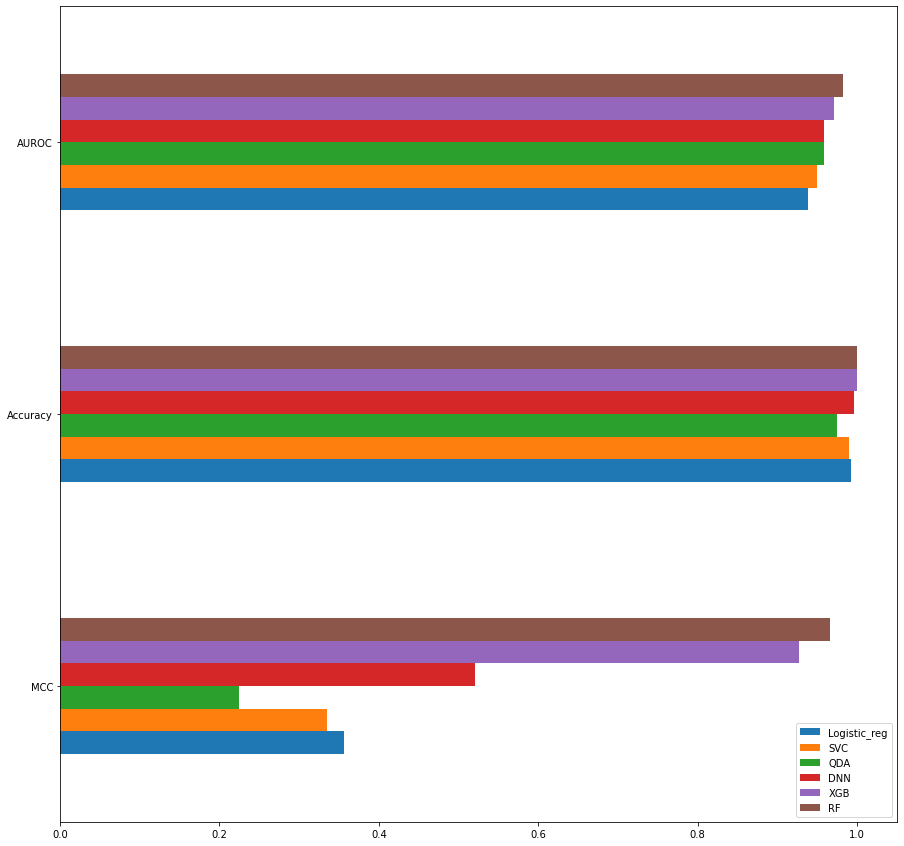

In [70]:
# Plot MCC, AUROC, Accuracy scores
MCC_summary = pd.DataFrame(MCC_scores)
MCC_summary.plot(kind='barh', figsize=(15, 15))

Deep Neural Network, XGBoost, Random Forrests have the highest MCC scores. Therefore, the trained models of these 3 will be saved for further applications

In [71]:
# Save the models
saved_DNN = pickle.dumps(model_DNN)
saved_RF = pickle.dumps(model_RF)
saved_XGB = pickle.dumps(model_xgb)



In [72]:
# Run optimization to maximize MCC
def mcc(x):
    # x[0], x[1], x[2] are the weights of DNN, RF, XGB 
    predicted = np.add(x[0]*pickle.loads(saved_DNN).predict(X_test), 
                       x[1]*pickle.loads(saved_RF).predict(X_test), 
                       x[2]*pickle.loads(saved_XGB).predict(X_test))
    round_to_tenths = [round(num, 0) for num in predicted]
    predicted = np.array(round_to_tenths, dtype = int)
    return (-1*matthews_corrcoef(y_test, predicted))

# Lower and upper bounds of the weights
bounds = Bounds([0, 0, 0], [1, 1, 1])
# Sum of the weights should be equal to 1
linear_constraint = LinearConstraint([1, 1, 1], [1], [1])

# x0 is the initial guess
x0 = np.array([0.2, 0.50, 0.3])
res = minimize(mcc, x0, method='trust-constr',
               constraints=[linear_constraint], 
               options={'verbose': 1}, bounds=bounds)


`gtol` termination condition is satisfied.
Number of iterations: 13, function evaluations: 16, CG iterations: 5, optimality: 9.55e-09, constraint violation: 0.00e+00, execution time: 2.2e+01 s.


In [73]:
# Print the weights of DNN, RF, XGB
print(res.x[0])
print(res.x[1])
print(res.x[2])

# Run the final predictive algorithm with weights
predicted = np.add(res.x[0]*model_DNN.predict(X_test), 
                   res.x[1]*model_RF.predict(X_test), 
                   res.x[2]*model_xgb.predict(X_test))

round_to_tenths = [round(num, 0) for num in predicted]
predicted = np.array(round_to_tenths, dtype = int)
# Print the MCC score
print(np.round(matthews_corrcoef(y_test, predicted), 2))

0.10007085879615009
0.7244258613669309
0.17550327983691916
0.97
